# feature selection 
reference : https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
st = time.time()
df = pd.read_csv('./new_feature_by_olivier_feature_matrix.csv')
time.time() - st

141.51371026039124

# drop IDs


In [3]:
id_columns = []
for c in df.columns:
    if 'SK_ID' in c :
        print(c)
        if c != 'SK_ID_CURR':
            id_columns.append(c)
df = df.drop(id_columns, axis = 1)

SK_ID_CURR
STD(cash.SK_ID_CURR)
MAX(cash.SK_ID_CURR)
SKEW(cash.SK_ID_CURR)
MIN(cash.SK_ID_CURR)
MEAN(cash.SK_ID_CURR)
STD(installments.SK_ID_CURR)
MAX(installments.SK_ID_CURR)
SKEW(installments.SK_ID_CURR)
MIN(installments.SK_ID_CURR)
MEAN(installments.SK_ID_CURR)
STD(credit.SK_ID_CURR)
MAX(credit.SK_ID_CURR)
SKEW(credit.SK_ID_CURR)
MIN(credit.SK_ID_CURR)
MEAN(credit.SK_ID_CURR)
STD(previous.MAX(cash.SK_ID_CURR))
STD(previous.SKEW(cash.SK_ID_CURR))
STD(previous.MIN(cash.SK_ID_CURR))
STD(previous.MEAN(cash.SK_ID_CURR))
STD(previous.MAX(installments.SK_ID_CURR))
STD(previous.SKEW(installments.SK_ID_CURR))
STD(previous.MIN(installments.SK_ID_CURR))
STD(previous.MEAN(installments.SK_ID_CURR))
STD(previous.MAX(credit.SK_ID_CURR))
STD(previous.SKEW(credit.SK_ID_CURR))
STD(previous.MIN(credit.SK_ID_CURR))
STD(previous.MEAN(credit.SK_ID_CURR))
MAX(previous.STD(cash.SK_ID_CURR))
MAX(previous.SKEW(cash.SK_ID_CURR))
MAX(previous.MIN(cash.SK_ID_CURR))
MAX(previous.MEAN(cash.SK_ID_CURR))
MAX(previo

In [4]:
df.to_csv('new_feature_by_olivier_feature_matrix_noIDs.csv', index = False)

# Remove missing values

In [5]:
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

print('Training set full shape: ', train_df.shape)
print('Testing set full shape: ' , test_df.shape)

# Train missing values (in percent)
train_missing = (train_df.isnull().sum() / len(train_df)).sort_values(ascending = False)
train_missing.head()

# Test missing values (in percent)
test_missing = (test_df.isnull().sum() / len(test_df)).sort_values(ascending = False)
test_missing.head()

# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

# Need to save the labels because aligning will remove this column
train_labels = train_df["TARGET"]

train_df = train_df.drop(columns = all_missing)
test_df = test_df.drop(columns = all_missing)

print('Training set full shape: ', train_df.shape)
print('Testing set full shape: ' , test_df.shape)

Training set full shape:  (307507, 1331)
Testing set full shape:  (48744, 1330)
There are 266 columns with more than 75% missing values
Training set full shape:  (307507, 1065)
Testing set full shape:  (48744, 1064)


In [6]:
df = df.drop(all_missing, axis = 1)
df.to_csv('new_feature_by_olivier_feature_matrix_noIDs_delmissing.csv', index = False)

In [7]:
df = df.drop('SK_ID_CURR', axis = 1)

# Lable Encoding

In [8]:
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


36

In [9]:
print('Training shape: ', train_df.shape)
print('Testing shape: ', test_df.shape)

Training shape:  (307507, 1064)
Testing shape:  (48744, 1063)


# make prediction

In [10]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=.8,
        subsample=.87,
        max_depth=8,
        reg_alpha=.0415,
        reg_lambda=.0735,
        min_split_gain=.02,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.759155	valid_1's auc: 0.753921
[200]	training's auc: 0.780278	valid_1's auc: 0.766217
[300]	training's auc: 0.797823	valid_1's auc: 0.7751
[400]	training's auc: 0.809371	valid_1's auc: 0.780386
[500]	training's auc: 0.818505	valid_1's auc: 0.782959
[600]	training's auc: 0.826642	valid_1's auc: 0.784799
[700]	training's auc: 0.833652	valid_1's auc: 0.785986
[800]	training's auc: 0.840204	valid_1's auc: 0.786838
[900]	training's auc: 0.846122	valid_1's auc: 0.787753
[1000]	training's auc: 0.851686	valid_1's auc: 0.788009
[1100]	training's auc: 0.856819	valid_1's auc: 0.788489
[1200]	training's auc: 0.861651	valid_1's auc: 0.788546
Early stopping, best iteration is:
[1156]	training's auc: 0.859534	valid_1's auc: 0.788745
Fold  1 AUC : 0.788745
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.759244	valid_1's auc: 0.74879
[200]	training's auc: 0.780357	valid_1's auc:

[600]	training's auc: 0.826618	valid_1's auc: 0.779422
[700]	training's auc: 0.833409	valid_1's auc: 0.780778
[800]	training's auc: 0.839891	valid_1's auc: 0.781596
[900]	training's auc: 0.84574	valid_1's auc: 0.782487
[1000]	training's auc: 0.851301	valid_1's auc: 0.783281
[1100]	training's auc: 0.856371	valid_1's auc: 0.783472
[1200]	training's auc: 0.861084	valid_1's auc: 0.784218
[1300]	training's auc: 0.86573	valid_1's auc: 0.784656
[1400]	training's auc: 0.870256	valid_1's auc: 0.785029
[1500]	training's auc: 0.874439	valid_1's auc: 0.785311
[1600]	training's auc: 0.878611	valid_1's auc: 0.785629
[1700]	training's auc: 0.882617	valid_1's auc: 0.785725
[1800]	training's auc: 0.886472	valid_1's auc: 0.786039
[1900]	training's auc: 0.890226	valid_1's auc: 0.786229
[2000]	training's auc: 0.893676	valid_1's auc: 0.786354
[2100]	training's auc: 0.897131	valid_1's auc: 0.786498
Early stopping, best iteration is:
[2060]	training's auc: 0.895721	valid_1's auc: 0.78654
Fold  9 AUC : 0.7865

[400]	training's auc: 0.808946	valid_1's auc: 0.790144
[500]	training's auc: 0.81824	valid_1's auc: 0.792873
[600]	training's auc: 0.8262	valid_1's auc: 0.794988
[700]	training's auc: 0.833309	valid_1's auc: 0.796221
[800]	training's auc: 0.839806	valid_1's auc: 0.796919
[900]	training's auc: 0.845985	valid_1's auc: 0.797387
[1000]	training's auc: 0.851433	valid_1's auc: 0.797672
[1100]	training's auc: 0.856796	valid_1's auc: 0.798099
[1200]	training's auc: 0.861778	valid_1's auc: 0.798367
[1300]	training's auc: 0.86637	valid_1's auc: 0.798452
Early stopping, best iteration is:
[1230]	training's auc: 0.863156	valid_1's auc: 0.798581
Fold 17 AUC : 0.798581
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.758948	valid_1's auc: 0.759363
[200]	training's auc: 0.779732	valid_1's auc: 0.775378
[300]	training's auc: 0.79722	valid_1's auc: 0.788111
[400]	training's auc: 0.808791	valid_1's auc: 0.794029
[500]	training's auc: 0.817971	valid_1's auc: 0.797443

In [11]:
sub.to_csv('./olivier_feature_matrix_25cv_tuned_by_Ivan_noIDs_delmissing_sub.csv', index=None)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


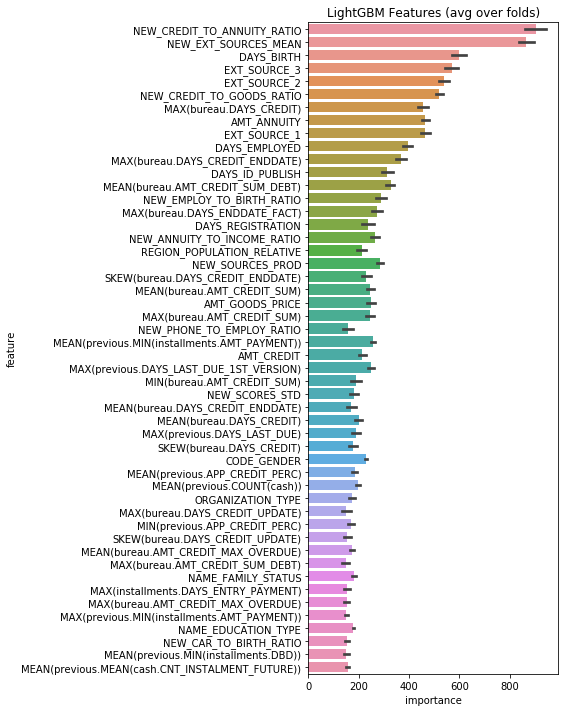

In [13]:
display_importances(feature_importance_df)

In [14]:
time.time() - st

20793.149385213852

In [15]:
feature_importances = feature_importance_df[["feature", "importance"]].groupby("feature").mean()

In [16]:
def norm_feature_importances(df, threshold = 0.95):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [17]:
norm_feature_importances = norm_feature_importances(feature_importances)

573 features required for 0.95 of cumulative importance


In [18]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
unimportant_features = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] >= threshold]['feature'])

In [19]:
df = pd.read_csv('./new_feature_by_olivier_feature_matrix_noIDs_delmissing.csv')
df = df.drop(unimportant_features, axis=1)
df.to_csv('./new_feature_by_olivier_feature_matrix_noIDs_delmissing_delunimportant.csv',  index=None)